<a href="https://colab.research.google.com/github/shreyasrajesh0308/NNDL-proj/blob/main/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Paper: 

### Load Data 

Load preprocessed data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:

X_test = np.load("/content/drive/MyDrive/eeg_project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/eeg_project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/eeg_project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/eeg_project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/eeg_project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/eeg_project/person_test.npy")


In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
print(np.unique(y_train_valid))
print(np.unique(y_test))

[769 770 771 772]
[769 770 771 772]


In [ ]:
num_classes = 4
y_train_valid = y_train_valid-769
y_test = y_test-769

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [ ]:
def data_prep_test(X,y, sub_sample=2):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    return total_X,total_y


X_test,y_test = data_prep_test(X_test, y_test,2)


Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)


In [ ]:

y_train_valid_prep = keras.utils.to_categorical(y_train_valid_prep, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
print(X_train_valid_prep.shape,y_train_valid_prep.shape)
print(X_test.shape, y_test.shape)

(8460, 22, 250) (8460,)
(443, 22, 250) (443,)


In [ ]:
X_train_valid_prep = np.swapaxes(X_train_valid_prep, 1, 2)
X_test = np.swapaxes(X_test, 1, 2)

In [ ]:
print(X_train_valid_prep.shape,y_train_valid_prep.shape)
print(X_test.shape, y_test.shape)

(8460, 250, 22) (8460,)
(443, 250, 22) (443,)


## Transformer model with all subjects

In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dense, Dropout, LSTM, Input, TimeDistributed, Permute, Reshape, MaxPooling2D, GRU
from keras import initializers, Model, optimizers, callbacks
from keras import Sequential
from keras import backend as K
from keras.models import load_model
from keras.callbacks import Callback
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [ ]:
input_shape = X_train_valid_prep.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

# callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 250, 22)]    0           []                               
                                                                                                  
 layer_normalization_40 (LayerN  (None, 250, 22)     44          ['input_6[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_20 (Multi  (None, 250, 22)     93206       ['layer_normalization_40[0][0]', 
 HeadAttention)                                                   'layer_normalization_40[0][0]'] 
                                                                                            

In [ ]:

model.fit(
    X_train_valid_prep,
    y_train_valid_prep,
    validation_split=0.2,
    epochs=200,
    batch_size=64
)

Epoch 1/200
106/106 [==============================] - 64s 473ms/step - loss: 11.5033 - sparse_categorical_accuracy: 0.2648 - val_loss: 6.8582 - val_sparse_categorical_accuracy: 0.2884
Epoch 2/200
106/106 [==============================] - 49s 463ms/step - loss: 8.6392 - sparse_categorical_accuracy: 0.2841 - val_loss: 5.1527 - val_sparse_categorical_accuracy: 0.3085
Epoch 3/200
106/106 [==============================] - 50s 469ms/step - loss: 7.1914 - sparse_categorical_accuracy: 0.2884 - val_loss: 4.3068 - val_sparse_categorical_accuracy: 0.3227
Epoch 4/200
106/106 [==============================] - 50s 470ms/step - loss: 5.8424 - sparse_categorical_accuracy: 0.3053 - val_loss: 3.4222 - val_sparse_categorical_accuracy: 0.3168
Epoch 5/200
106/106 [==============================] - 50s 470ms/step - loss: 3.7788 - sparse_categorical_accuracy: 0.2937 - val_loss: 1.7776 - val_sparse_categorical_accuracy: 0.2908
Epoch 6/200
106/106 [==============================] - 49s 459ms/step - loss: 1

In [ ]:
model.evaluate(X_test, y_test)

NameError: ignored

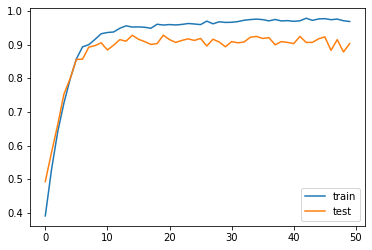

In [ ]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();